In [7]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

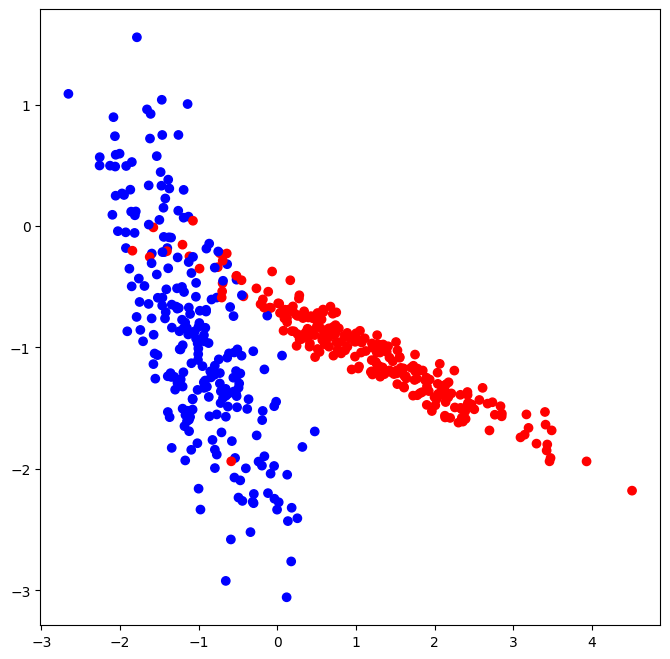

In [8]:
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);



random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # здесь надо генерировать bootstrap выборки

        bootstrap.append((b_data, b_labels))

    return bootstrap


def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

In [9]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [10]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # Самый частый класс в листе
        if len(self.labels) == 0:
            return 0

        unique_classes, counts = np.unique(self.labels, return_counts=True)
        prediction = unique_classes[np.argmax(counts)]
        return prediction

# Расчет критерия Джини
def gini(labels):
    if len(labels) == 0:
        return 0

    # Подсчет вероятностей классов
    unique_classes, counts = np.unique(labels, return_counts=True)
    impurity = 1.0
    total = len(labels)

    for count in counts:
        prob = count / total
        impurity -= prob ** 2

    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # Доли выборок
    p = float(len(left_labels)) / (len(left_labels) + len(right_labels))

    # Взвешенный критерий Джини
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):
    true_mask = data[:, index] <= t
    false_mask = ~true_mask

    true_data = data[true_mask]
    false_data = data[false_mask]
    true_labels = labels[true_mask]
    false_labels = labels[false_mask]

    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    # Обозначим минимальное количество объектов в узле
    min_leaf = 1

    best_quality = 0
    best_t = None
    best_index = None

    current_gini = gini(labels)
    n_features = data.shape[1]

    # Случайный выбор подмножества признаков (√n_features)
    feature_indices = random.sample(range(n_features), int(np.sqrt(n_features)))

    for index in feature_indices:
        # Уникальные значения признака
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            # Пропускаем разбиения, где в одной из частей меньше min_leaf объектов
            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            if current_quality > best_quality:
                best_quality = current_quality
                best_t = t
                best_index = index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_depth=10, depth=0):
    # Если достигли максимальной глубины или все объекты одного класса
    if depth >= max_depth or len(np.unique(labels)) == 1:
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels)

    # Базовый случай - прекращаем рекурсию, когда нет прироста в качестве
    if quality == 0 or t is None:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Если одна из веток пуста
    if len(true_labels) == 0 or len(false_labels) == 0:
        return Leaf(data, labels)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, depth + 1)
    false_branch = build_tree(false_data, false_labels, max_depth, depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

# Bootstrap выборка
def get_bootstrap(data, labels, n_trees):
    bootstrap = []
    n_samples = len(data)

    for i in range(n_trees):
        # Случайный выбор с возвращением
        indices = np.random.randint(0, n_samples, n_samples)
        bootstrap.append((data[indices], labels[indices]))

    return bootstrap

def random_forest(data, labels, n_trees=10, max_depth=10):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    # строим лес
    for data_sample, labels_sample in bootstrap:
        tree = build_tree(data_sample, labels_sample, max_depth)
        forest.append(tree)

    return forest

# Функция классификации отдельного объекта
def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# Функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    predictions = []
    for obj in data:
        pred = classify_object(obj, tree)
        predictions.append(pred)
    return predictions

# Функция для нахождения самого частого элемента в массиве
def most_frequent(arr):
    if len(arr) == 0:
        return None

    unique_elements, counts = np.unique(arr, return_counts=True)
    return unique_elements[np.argmax(counts)]

# Предсказание голосованием деревьев
def tree_vote(forest, data):
    # Собираем предсказания от всех деревьев
    all_predictions = []
    for tree in forest:
        tree_predictions = predict(data, tree)
        all_predictions.append(tree_predictions)

    # Транспонируем, чтобы получить предсказания для каждого объекта
    all_predictions = np.array(all_predictions).T

    # Голосование по большинству для каждого объекта
    voted_predictions = []
    for obj_predictions in all_predictions:
        # Самый частый класс
        voted_pred = most_frequent(obj_predictions)
        voted_predictions.append(voted_pred)

    return voted_predictions

In [11]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)


  # Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

Точность случайного леса из 1 деревьев на обучающей выборке: 96.571
Точность случайного леса из 1 деревьев на тестовой выборке: 94.667


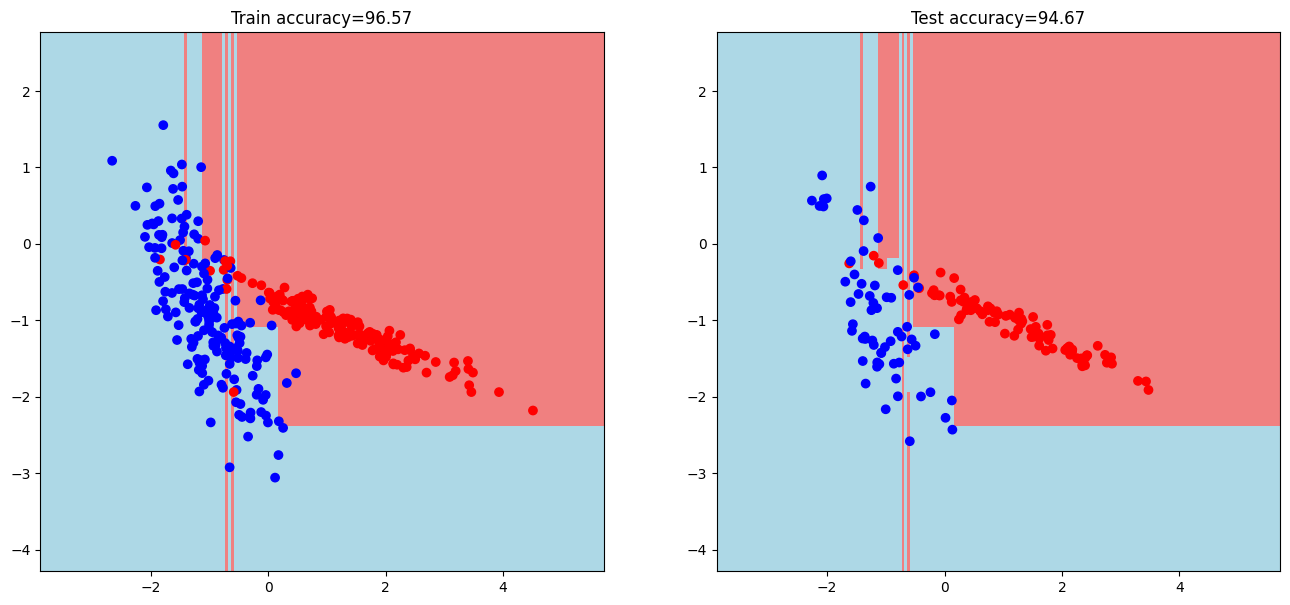

In [12]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Точность случайного леса из 3 деревьев на обучающей выборке: 99.714
Точность случайного леса из 3 деревьев на тестовой выборке: 94.000


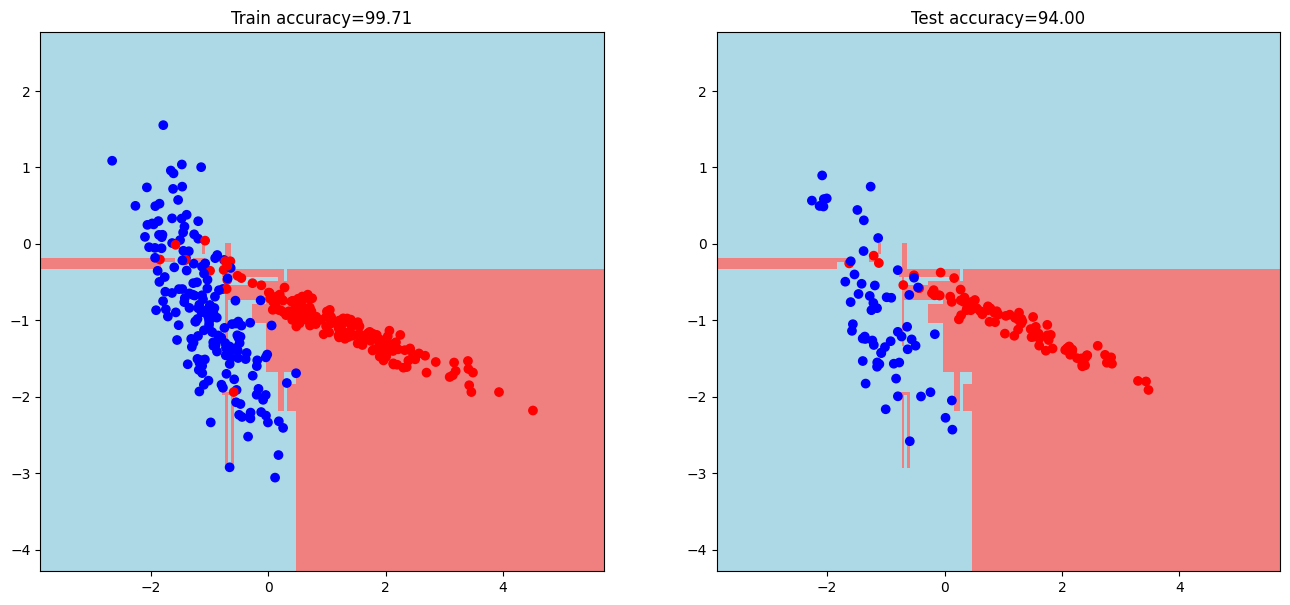

In [13]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Точность случайного леса из 10 деревьев на обучающей выборке: 99.429
Точность случайного леса из 10 деревьев на тестовой выборке: 95.333


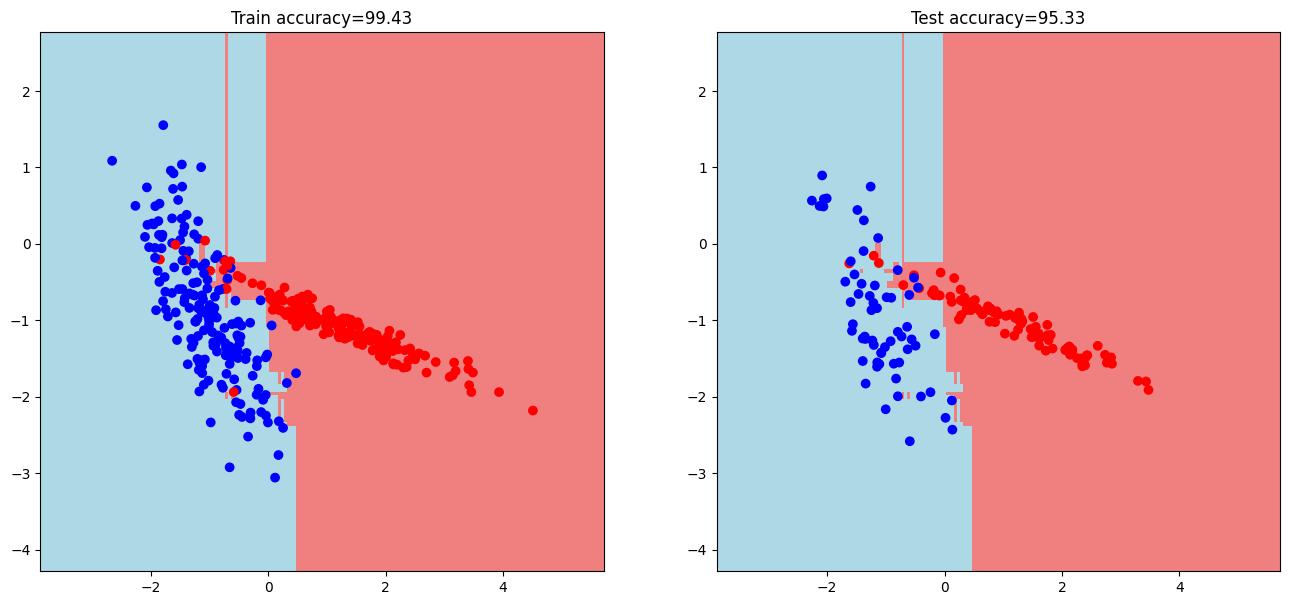

In [14]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Точность случайного леса из 50 деревьев на обучающей выборке: 99.714
Точность случайного леса из 50 деревьев на тестовой выборке: 94.667


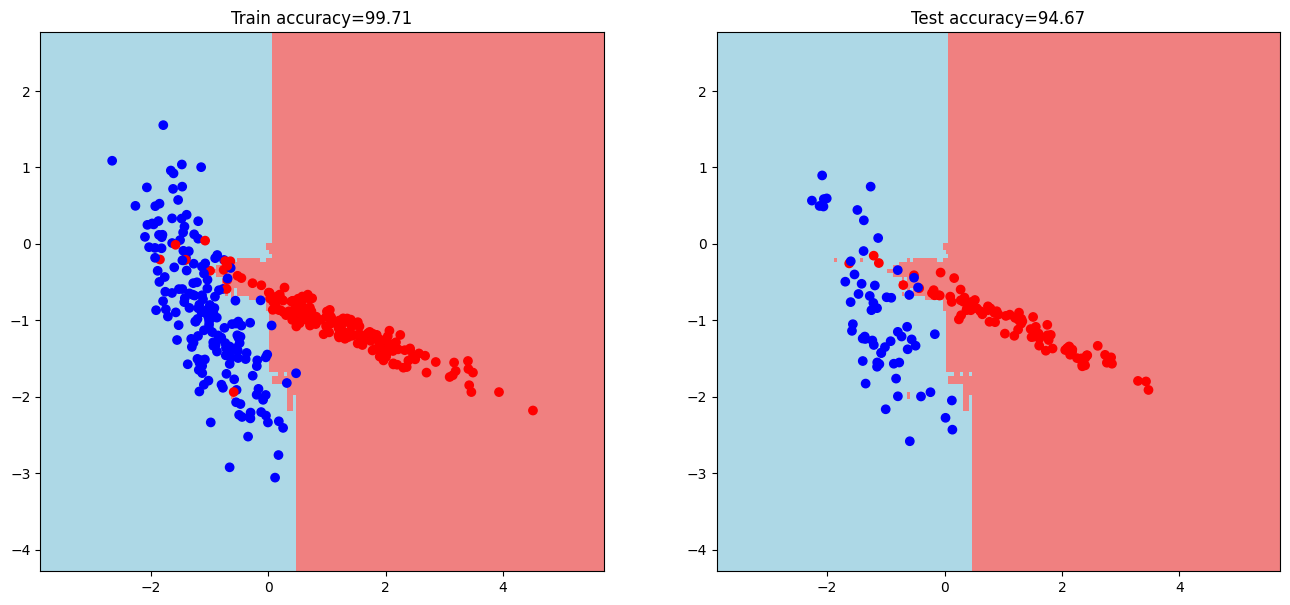

In [15]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()